In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression

In [2]:
# connexion a la base de donnees
conn = sqlite3.connect('../Datas/db/fraude_detection_warehouse_.db')

In [3]:
# Extraction des tables
tables = {
    'alerts': pd.read_sql_query("SELECT * FROM alerts", conn),
    'customers': pd.read_sql_query("SELECT * FROM customers", conn),
    'devices': pd.read_sql_query("SELECT * FROM devices", conn),
    'transaction_history': pd.read_sql_query("SELECT * FROM transaction_history", conn),
    'transaction_patterns': pd.read_sql_query("SELECT * FROM transaction_patterns", conn),
    'transactions': pd.read_sql_query("SELECT * FROM transactions", conn)
}

tables['alerts']


,alert_id,transaction_id,alert_date,alert_type,alert_status,description
0,51a83841-582a-49f0-b1b7-534b593f02d8,19a371c6131c4fadaaa4b59555d41927,2022-04-25 03:40:24,large transaction,closed,Woman life might health ever statement range.\...
1,3eb26fef-a1cf-49e2-ba05-23c0c72a4f7f,5462c26c89794e108f33acd5a6aba434,2020-05-08 18:50:52,large transaction,open,Both his benefit especially development wester...
2,b9103754-365e-42c6-a263-3cd296504dcd,8ad7f3906e4d410988894e9983e21cad,2021-09-10 03:36:03,large transaction,closed,Structure night election civil old. White boy ...
3,5df28a26-9f75-40bc-82a2-a2a43da4f3b8,b9504927c22846babb4943e2597f11c9,2022-04-02 08:03:32,suspicious activity,closed,White big create light blood commercial countr...
4,acc68d65-0fea-4541-a7aa-e0982fdfd4fe,1fc48491d2724c8fb2c3d7ab08c339c8,2024-02-22 10:38:47,large transaction,open,Look her cost. Later which black computer.\nLi...
...,...,...,...,...,...,...
95,a3691dfb-32fd-4dde-bc53-7c81b7a44e7d,244b27709baf45c49a02455eb9ce4834,2023-10-11 00:17:06,suspicious activity,open,Half today at small medical mind crime. Includ...
96,b16592fa-7f1e-47ae-b3c7-036caf9f1bc5,f3573c22bfce44909544faee64849e34,2020-01-02 23:14:28,suspicious activity,open,From feel consumer low trial. Marriage profess...
97,a272ab65-dba2-45bd-be77-f62b8a0bb4de,026ddb4c8e4c41d9b1d79b0c2645f51b,2022-05-26 15:52:16,suspicious activity,open,Soon for economy billion situation box. Becaus...
98,690bde2c-d0fe-46f2-85da-6a5d4c6c47be,c3e5e0f44101408a992d919dd8306b7c,2023-12-26 07:49:51,suspicious activity,open,Near letter responsibility born term she. Mode...


In [4]:
# Fusion des tables
df1 = tables['transactions'].merge(tables['customers'], on='customer_id', how='left').drop(columns=['first_name', 'last_name'])
df2 = df1.merge(tables['devices'], on='device_id', how='left')
df3 = df2.merge(tables['transaction_history'], on=['customer_id', 'transaction_id'], how='left')

df3

,transaction_id,customer_id,device_id,transaction_date_x,transaction_type,amount,status,is_fraud,location,email,...,region,device_type,os,manufacturer,model,last_used,history_id,previous_balance,new_balance,transaction_date_y
0,731b17cfadce442ab756b5b110a406c2,d159ae25b3d04387bbc006b8f0df4629,f66d0310-bf70-4552-a732-5950c93b1134,2020-02-12,depôt,9.385805e+06,réussie,1,Douala,Kim.Nguyen@lopez-wolfe.com,...,Centre,tablette,linux,LG,envy45,2023-12-01 16:08:02,1e9c3c0fc0b1496d8d2901d0f8f3531d,1.933918e+07,2.872498e+07,2020-02-12
1,96f4ac611eaa4174b39149d98e569810,84d0894d1b9a4a8dbe13cfbb32d451df,f765ead3-ca24-48f4-9252-a6fd5fc53518,2022-02-03,depôt,3.358191e+06,réussie,0,Bafoussam,Gregory.Webb@scott.com,...,Ouest,tablette,ios,SONY,Bravia OLDE,2020-09-12 09:19:47,d9970217233245029374bceecdc315c0,9.557160e+06,1.291535e+07,2022-02-03
2,1c11b97ba2994efbb6f85291e7062e00,b01c160bdd134ac989f1d0d0163ac149,9cac18d3-defc-4142-9a39-b66fe1063f6e,2019-11-09,depôt,7.307758e+06,réussie,1,Bafoussam,Mary.Frank@mcbride-oliver.biz,...,Ouest,mobile,ios,SONY,Xperia 1 III,2020-10-05 12:26:19,76fcc12cfc944467b6465cd0aba2893c,1.430163e+07,2.160939e+07,2019-11-09
3,99d146a3fbd04a38a5b83190b4ec22e3,31bd9c0aa340439899f52de6d89ac6eb,40ccde62-b98d-4e6b-bd3f-bf514cae73b9,2018-07-18,transfert,3.127519e+06,réussie,1,Bafoussam,Mark.Nelson@yang.info,...,Ouest,tablette,ios,Apple,iphone 13,2020-05-29 13:34:21,3bb9c05095104929b845b85e2daa86e8,7.646344e+06,4.518825e+06,2018-07-18
4,bdab6a6430b44fadbf2f1682ccda4ae8,ade32958209d40cfb475e5bef5a2b4a3,16aa8a04-4cbd-48dc-88d2-ef9d0e8a2944,2019-12-29,retrait,4.435274e+06,réussie,0,Yaoundé,Deborah.Stokes@faulkner-randall.net,...,Littoral,mobile,android,HP,envy 13,2021-04-30 12:36:51,64f19595555c42c5ae3d1fb9eb17c793,9.679731e+06,5.244457e+06,2019-12-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,9fad54904d0249bf88ea359decad2fe1,9796bd0339444a84a91020bd68aded49,92b5d329-0398-4b94-83a8-9a1eec5d80d7,2020-10-20,depôt,1.823679e+06,réussie,0,Bamessi,Ronnie.Walker@guzman.com,...,Nord,mobile,linux,Apple,iphone 13,2022-05-24 23:09:12,8eb63428e80a4e42bd85b3301cef4ae4,5.742065e+06,7.565744e+06,2020-10-20
99996,1615f8419cf64b64ab2333c834df9cce,dcb272c3f7df4be48e6ea3635a8d2d17,a9590ed6-7edc-441d-ab56-5ef60fe67635,2022-03-22,transfert,4.385222e+06,réussie,0,Touboro,Stacey.Stone@thomas-lopez.org,...,Littoral,tablette,android,LG,Gram 17,2023-12-11 03:38:30,bbd1114bfe3940ef9c98980fdb27fea8,6.952369e+06,2.567147e+06,2022-03-22
99997,f5318036e2e44f688c3f1ee2cab34948,ea0df742b78a4639b0615eb3caa8d74c,a28f2d34-ae90-4a91-acf8-bcc85d47131e,2022-10-02,transfert,5.179289e+06,échouée,1,Bogo,Cody.Long@johnson.org,...,Centre,tablette,mac,SONY,Xperia 5 II,2021-11-05 22:02:54,54ee0a0f0d85470cb71042d79cd97ea5,1.483910e+07,9.659806e+06,2022-10-02
99998,f8264b2655a34de2815066d0f90f56cb,a864cb2d432e473c8e8917feb60289d5,bcb70ba7-213c-48b7-b74b-cd0dd038fdea,2022-07-30,transfert,8.017831e+06,réussie,0,Dschang,David.Mclaughlin@colon.com,...,Ouest,mobile,mac,HP,spectre x360,2023-03-15 14:30:35,b1779bd5459c4bb2a491ebdec5e4b2b4,9.250424e+06,1.232594e+06,2022-07-30


In [5]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   transaction_id      100000 non-null  object 
 1   customer_id         100000 non-null  object 
 2   device_id           100000 non-null  object 
 3   transaction_date_x  100000 non-null  object 
 4   transaction_type    100000 non-null  object 
 5   amount              100000 non-null  float64
 6   status              100000 non-null  object 
 7   is_fraud            100000 non-null  int64  
 8   location            100000 non-null  object 
 9   email               100000 non-null  object 
 10  phone_number        100000 non-null  object 
 11  registration_date   100000 non-null  object 
 12  date_of_birth       100000 non-null  object 
 13  address             100000 non-null  object 
 14  city                100000 non-null  object 
 15  region              100000 non-null

In [6]:
df3.describe()

,amount,is_fraud,previous_balance,new_balance
count,1.000000e+05,100000.000000,1.000000e+05,1.000000e+05
mean,5.587385e+06,0.567070,1.057399e+07,1.057244e+07
std,3.514901e+06,0.495484,4.556663e+06,8.011172e+06
min,1.639254e+02,0.000000,7.688654e+04,9.024776e+00
25%,2.660834e+06,0.000000,7.279777e+06,4.493306e+06
50%,5.309755e+06,1.000000,1.042128e+07,8.351001e+06
75%,8.046252e+06,1.000000,1.371817e+07,1.563911e+07
max,1.574056e+07,1.000000,2.505568e+07,4.037580e+07


In [7]:
# Encodage des variables categorielles
le = LabelEncoder()
categorical_columns = df3.select_dtypes(include=['object']).columns
for col in categorical_columns:
    df3[col] = le.fit_transform(df3[col].astype(str))

In [8]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   transaction_id      100000 non-null  int32  
 1   customer_id         100000 non-null  int32  
 2   device_id           100000 non-null  int32  
 3   transaction_date_x  100000 non-null  int32  
 4   transaction_type    100000 non-null  int32  
 5   amount              100000 non-null  float64
 6   status              100000 non-null  int32  
 7   is_fraud            100000 non-null  int64  
 8   location            100000 non-null  int32  
 9   email               100000 non-null  int32  
 10  phone_number        100000 non-null  int32  
 11  registration_date   100000 non-null  int32  
 12  date_of_birth       100000 non-null  int32  
 13  address             100000 non-null  int32  
 14  city                100000 non-null  int32  
 15  region              100000 non-null

In [10]:
df3.describe()

,transaction_id,customer_id,device_id,transaction_date_x,transaction_type,amount,status,is_fraud,location,email,...,region,device_type,os,manufacturer,model,last_used,history_id,previous_balance,new_balance,transaction_date_y
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.00000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,1.000000e+05,100000.000000
mean,49999.500000,4997.011860,31643.889520,1094.728150,0.750080,5.587385e+06,0.100280,0.567070,44.62189,5003.649140,...,11.410060,0.502170,1.994680,2.507990,11.042960,31561.620300,49999.500000,1.057399e+07,1.057244e+07,1094.728150
std,28867.657797,2891.162648,18264.383083,632.196196,0.829811,3.514901e+06,0.300374,0.495484,30.26825,2893.387413,...,4.824129,0.499998,1.409231,1.706472,6.654639,18256.170686,28867.657797,4.556663e+06,8.011172e+06,632.196196
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.639254e+02,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.688654e+04,9.024776e+00,0.000000
25%,24999.750000,2496.000000,15760.750000,548.000000,0.000000,2.660834e+06,0.000000,0.000000,16.00000,2485.000000,...,7.000000,0.000000,1.000000,1.000000,5.000000,15724.750000,24999.750000,7.279777e+06,4.493306e+06,548.000000
50%,49999.500000,4988.000000,31739.500000,1095.000000,0.000000,5.309755e+06,0.000000,1.000000,37.00000,5008.000000,...,13.000000,1.000000,2.000000,3.000000,11.000000,31561.500000,49999.500000,1.042128e+07,8.351001e+06,1095.000000
75%,74999.250000,7499.000000,47447.000000,1642.000000,2.000000,8.046252e+06,0.000000,1.000000,74.00000,7511.000000,...,14.000000,1.000000,3.000000,4.000000,17.000000,47342.250000,74999.250000,1.371817e+07,1.563911e+07,1642.000000
max,99999.000000,9999.000000,63258.000000,2191.000000,2.000000,1.574056e+07,1.000000,1.000000,101.00000,9998.000000,...,21.000000,1.000000,4.000000,5.000000,22.000000,63245.000000,99999.000000,2.505568e+07,4.037580e+07,2191.000000


In [9]:
# Conversion des dates en timestamp
date_columns = ['transaction_date', 'registrations_date', 'date_of_birth']
for col in date_columns:
    df3(col) == pd.to_datetime(df3[col]).astype(int) / 10**9

TypeError: 'DataFrame' object is not callable

In [ ]:
lignes_avec_manquantes = df3[df3.isnull().any(axis=1)]

nombre_lignes_manquantes = lignes_avec_manquantes.shape[0]

print("Nombre de lignes avec des valeurs manquantes :", nombre_lignes_manquantes)

Nombre de lignes avec des valeurs manquantes : 0


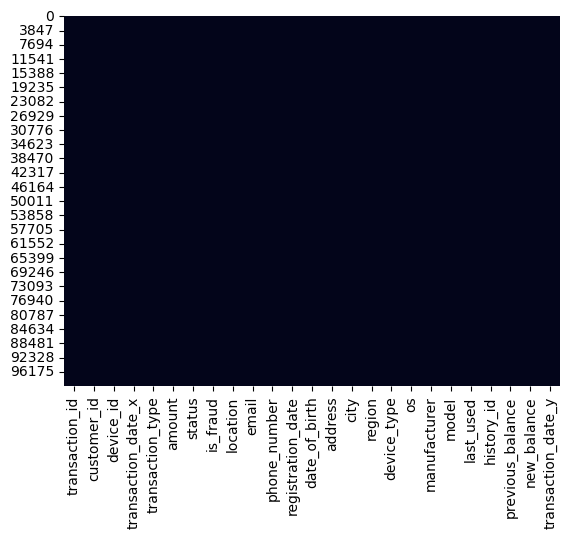

In [ ]:
# Visualiser les valeurs manquantes dans un DataFrame 
sns.heatmap(df3.isnull(), cbar=False)
plt.show()

In [ ]:
# Gestion des valeurs manquantes
# df3 = df3.fillna(df3.mean())

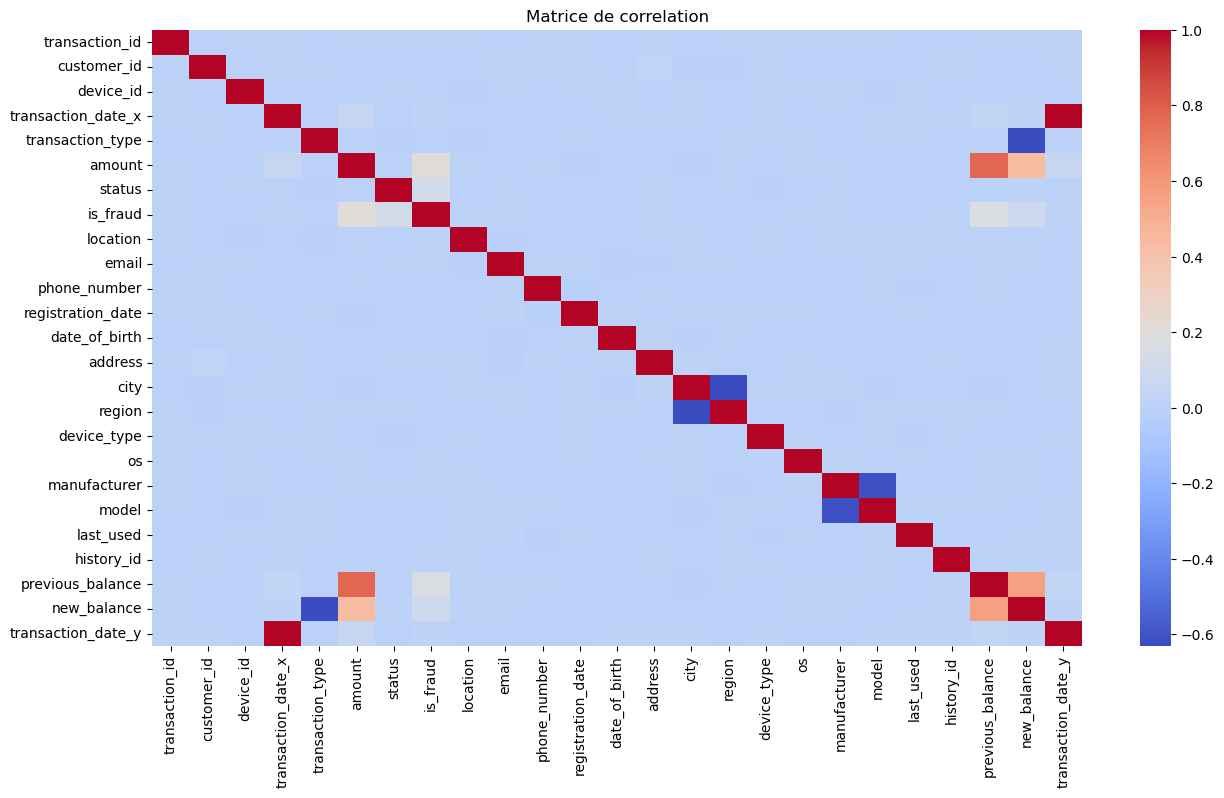

In [ ]:
# Analyse de correlation
corr_matrix = df3.corr()
plt.figure(figsize=(15, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Matrice de correlation')
plt.show()

In [ ]:
# Selection des variables les plus correlees avec is_fraud
correlations_with_fraud = corr_matrix['is_fraud'].abs().sort_values(ascending=False)
print("Top 10 variables les plus corrélées avec is_fraud:")
print(correlations_with_fraud.head(10))

Top 10 variables les plus corrélées avec is_fraud:
is_fraud              1.000000
amount                0.209955
previous_balance      0.162420
status                0.115933
new_balance           0.092639
transaction_date_y    0.016235
transaction_date_x    0.016235
location              0.004971
city                  0.004961
model                 0.004522
Name: is_fraud, dtype: float64


L'information mutuelle est une mesure statistique qui quantifie la dépendance entre deux variables.

ici, Calcule l'information mutuelle entre chaque variable explicative et la variable cible. 

In [ ]:
# Information mutuelle
X = df3.drop(columns=['is_fraud']) #Contient les variables explicatives (indépendantes)
y = df3['is_fraud'] #Contient la variable cible (dépendante)
mi_scores = mutual_info_regression(X, y)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)
print("\nTop 10 variables selon l'information mutuelle:")
print(mi_scores.head(10))


Top 10 variables selon l'information mutuelle:
amount                0.031331
last_used             0.017284
device_id             0.015487
previous_balance      0.013814
new_balance           0.008820
status                0.006920
transaction_date_y    0.005159
location              0.003496
device_type           0.002199
transaction_date_x    0.002033
Name: MI Scores, dtype: float64


In [ ]:
# Sélection finale des variables importantes
important_features = list(set(list(correlations_with_fraud.head(10).index) + list(mi_scores.head(10).index)))
important_features = [f for f in important_features if f != 'is_fraud']
print("\nVariables importantes sélectionnées:")
print(important_features)


Variables importantes sélectionnées:
['last_used', 'location', 'device_type', 'transaction_date_x', 'transaction_date_y', 'status', 'city', 'device_id', 'new_balance', 'model', 'amount', 'previous_balance']


In [ ]:
# Creation du dataset final
X_final = df3[important_features]
y_final = df3['is_fraud']

In [ ]:
# Entrainement du modele avec Isolation Forest
model = IsolationForest(contamination=0.5, random_state=42)
y_pred = model.fit_predict(X_final)

c:\Users\ESPace-TEK\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [ ]:
y_pred

array([-1,  1,  1, ..., -1,  1,  1])

Isolation Forest: calcule un score d'anomalie pour chaque observation du dataset. Ce score donne une mesure de la normalité de chaque observation en fonction de l'ensemble des données.

In [ ]:
# Ajout des predictions du DataFrame
df3['anomaly'] = y_pred

In [ ]:
# Affichage des resultats
print("\nNombre d'anomalies detectees:", sum(y_pred == -1))
print("\nExemples d'anomalies detectees:")
print(df3[df3['anomaly'] == -1].head()) # sélectionne uniquement les lignes du DataFrame df où la condition est True (c'est-à-dire les lignes correspondant aux anomalies).


Nombre d'anomalies detectees: 50000

Exemples d'anomalies detectees:
   transaction_id  customer_id  device_id  transaction_date_x  \
0           45184         8116      60985                 772   
3           60171         1886      16027                 198   
5           27378         1763       8486                1464   
6           52653         6622        643                 610   
7           85227         4213      49353                2162   

   transaction_type        amount  status  is_fraud  location  email  ...  \
0                 0  9.385805e+06       0         1        31   5665  ...   
3                 2  3.127519e+06       0         1        11   6467  ...   
5                 0  8.835403e+06       0         1        16   2906  ...   
6                 1  7.034970e+06       0         1        98   5180  ...   
7                 1  4.644982e+06       0         0        31   6979  ...   

   device_type  os  manufacturer  model  last_used  history_id  \
0         

In [ ]:
# evaluons la precision du modele
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Convertir les prédictions de l'Isolation Forest (-1 pour anomalie, 1 pour normal) 
# en format binaire (1 pour anomalie, 0 pour normal)
y_pred_binary = [1 if pred == -1 else 0 for pred in y_pred]

# Calculer et afficher les métriques de classification
print(classification_report(y_final, y_pred_binary))

# Calculer l'AUC-ROC
auc_roc = roc_auc_score(y_final, y_pred_binary)
print(f"AUC-ROC: {auc_roc}")

              precision    recall  f1-score   support

           0       0.48      0.55      0.51     43293
           1       0.61      0.54      0.57     56707

    accuracy                           0.54    100000
   macro avg       0.54      0.54      0.54    100000
weighted avg       0.55      0.54      0.55    100000

AUC-ROC: 0.5443276106170105


In [ ]:
# Afficher la matrice de confusion
print("Matrice de confusion:")
print(confusion_matrix(y_final, y_pred_binary))

Matrice de confusion:
[[23823 19470]
 [26177 30530]]
